# Malaria Detection

## Import

In [1]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from my_ml_lib import DataManipulationTools, MetricTools, PlotTools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Import different classifiers
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern, greycomatrix, greycoprops

## Functions

## Read dataset:

In [4]:
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

## Save / Load Extracted Features:

In [5]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

## Save / Load Trained Model:

In [6]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

## Features:

### Histogram of oriented gradients (HOG) based Features:

In [7]:
# def get_hog(images, name='hog', save=False):
#     result = np.array([hog(img, block_norm='L2') for img in images])
    
#     if save:
#         save_feature(result, name)
        
#     return result

In [8]:
def get_hog(images, name='hog', save=False):
    # HOG Feature Extraction
    cell_size = (4, 4)    # h x w in pixels
    block_size = (2, 2)     # h x w in cells
    nbins = 9
    
    # winSize is the size of the image cropped to an multiple of the cell size
    # cell_size is the size of the cells of the img patch over which to calculate the histograms
    # block_size is the number of cells which fit in the patch
    hog_desc = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                              images[0].shape[0] // cell_size[0] * cell_size[0]),
                                    _blockSize=(block_size[1] * cell_size[1],
                                                block_size[0] * cell_size[0]),
                                    _blockStride=(cell_size[1], cell_size[0]),
                                    _cellSize=(cell_size[1], cell_size[0]),
                                    _nbins=nbins)
    
    def get_image_hog(image):
        # HOG feature
        f = hog_desc.compute(image)
        
        res = np.array(f)
        return res.flatten()
    
    # HOG for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_hog(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

### Gabor based Features:

In [9]:
def get_gabor(images, name="gabor", save=False):
    
    # Gabor filter banks with different orientations and at different scales
    filters = []
    ksize = 9
    sigma = 0.1
    gamma = 0.5
    phi = 0
    
    # define the range for theta and nu
    for theta in np.arange(0, np.pi, np.pi / 8):
        for nu in np.arange(0, 6*np.pi/4, np.pi / 4):
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, nu, gamma, phi, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    
    # function to convolve the image with the filters
    def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum
        
    
    def get_image_gabor(image):
        # Local Binary Pattern
        f = []

        # calculating the local energy for each convolved image
        for j in range(40):
            res = process(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), filters[j])
            res = np.array(res)
            f.append(np.sum(np.multiply(res, res)))

        # calculating the mean amplitude for each convolved image
        for j in range(40):
            res = process(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), filters[j])
            res = np.array(res)
            f.append(np.sum(abs(res)))
        return f
    
    # Gabor descriptor for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_gabor(img)
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

### KAZE based features:

In [10]:
def get_kaze(images, name='kaze', save=False):
    
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        algo = cv2.KAZE_create()
        kps = algo.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = algo.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Scale-invariant feature transform (SIFT) based Features:

In [11]:
def get_sift(images, name='sift', save=False):
    
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result


In [12]:
def return_sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### Speeded-up robust features (SURF) based Features:

In [13]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [14]:
def return_surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### Local-Binary-Pattern (LBP) based Features:

In [15]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

### Gray Level Co-occurrence Matrix (GLCM) based Features:

In [16]:
def get_glcm(images, name='glcm', save=False):
    
    # GLCM feature for 1 image
    def get_image_glcm(img):
        image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # GLCM Feature Extraction
        Grauwertmatrix = greycomatrix(image, [1, 2, 3], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
                                                  symmetric=False, normed=True)
        
        contrast = greycoprops(Grauwertmatrix, 'contrast')
        dissimilarity = greycoprops(Grauwertmatrix, 'dissimilarity')
        homogeneity = greycoprops(Grauwertmatrix, 'homogeneity')
        energy = greycoprops(Grauwertmatrix, 'energy')
        correlation = greycoprops(Grauwertmatrix, 'correlation')
        ASM = greycoprops(Grauwertmatrix, 'ASM')
        
        # Merge all the features
        f = np.array([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
        return f.flatten()
    
    
    # GLCM descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_glcm(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Flattened Image:

In [17]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

### Color Histograms:

In [18]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

### Combine Features:

In [19]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

### Normalize features:

In [20]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [21]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

## Classifiers:

In [22]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['NB', 'SVM', 'XGB', 'MLP', 'ADA', 'BAG', 'RF']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

### ROC

In [23]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [24]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

### CM

In [25]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

### PCA projected data

In [26]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,30))
    for i, img in enumerate(mat, start=1):
        plt.subplot(5, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

In [27]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

## Main cells

## Read and split data

### Read and Store

In [27]:
full_data_x, full_data_y = read_images('cell_images')

In [28]:
print("dataset size : ", full_data_x.shape, full_data_y.shape)

dataset size :  (27558, 32, 32, 3) (27558,)


In [29]:
print("One Image size: ", full_data_x[2].shape)

One Image size:  (32, 32, 3)


In [30]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [31]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)

In [32]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape) 
print("Test data :", test_x.shape, "         Label: ", test_y.shape) 

Train data : (17636, 32, 32, 3)        Label:  (17636,)
Validation data : (4410, 32, 32, 3)    Label:  (4410,)
Test data : (5512, 32, 32, 3)          Label:  (5512,)


### Save train, validation, test data

In [33]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

np.save('data/data_x.npy', data_x)
np.save('data/data_y.npy', data_y)
np.save('data/test_x.npy', test_x)
np.save('data/test_y.npy', test_y)

### Load 

In [28]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

data_x = np.load('data/data_x.npy')
data_y = np.load('data/data_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')

In [29]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [30]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

## Training

### Training & Validation set features:


#### Data visualization:

In [37]:
infected_img = train_imgs[train_y == 0][0]
uninfected_img = train_imgs[train_y == 1][0]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [38]:
hog_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
sift = np.zeros((2, 32, 32, 3), dtype='uint8')
surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, hog_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_sift_kp(classes[i]))
    surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_surf_kp(classes[i]))

In [39]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(hog_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
for i in range(len(classes)):
    data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
for i in range(len(classes)):
    img_name_arr.append('SURF')

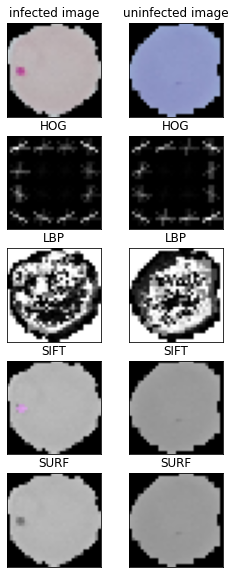

In [40]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()


### HOG features:

In [41]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [31]:
hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

In [32]:
hog_train.shape, hog_val.shape

((17636, 1764), (4410, 1764))

### LBP features:

In [44]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [33]:
lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

In [34]:
lbp_train.shape, lbp_val.shape

((17636, 1024), (4410, 1024))

### KAZE Features:

In [47]:
kaze_train = get_kaze(train_imgs, name='kaze_train', save=True)
kaze_val = get_kaze(val_imgs, name='kaze_val', save=True)

Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [35]:
kaze_train = load_feature('cache/kaze_train.pkl')
kaze_val = load_feature('cache/kaze_val.pkl')

In [36]:
kaze_train.shape, kaze_val.shape

((17636, 2048), (4410, 2048))

### SIFT Features:

In [50]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [37]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [38]:
sift_train.shape, sift_val.shape

((17636, 1920), (4410, 1920))

### SURF Features:

In [53]:
surf_train = get_surf(train_imgs, name='surf_train', save=True)
surf_val = get_surf(val_imgs, name='surf_val', save=True)

Feature saved with name cache/surf_train.pkl
Feature saved with name cache/surf_val.pkl


In [39]:
surf_train = load_feature('cache/surf_train.pkl')
surf_val = load_feature('cache/surf_val.pkl')

In [40]:
surf_train.shape, surf_val.shape

((17636, 256), (4410, 256))

### Gabor Features:

In [56]:
gabor_train = get_gabor(train_imgs, name='gabor_train', save=True)
gabor_val = get_gabor(val_imgs, name='gabor_val', save=True)

Feature saved with name cache/gabor_train.pkl
Feature saved with name cache/gabor_val.pkl


In [41]:
gabor_train = load_feature('cache/gabor_train.pkl')
gabor_val = load_feature('cache/gabor_val.pkl')

In [42]:
gabor_train.shape, gabor_val.shape

((17636, 80), (4410, 80))

### GLCM Features:

In [74]:
glcm_train = get_glcm(train_imgs, name='glcm_train', save=True)
glcm_val = get_glcm(val_imgs, name='glcm_val', save=True)

Feature saved with name cache/glcm_train.pkl
Feature saved with name cache/glcm_val.pkl


In [43]:
glcm_train = load_feature('cache/glcm_train.pkl')
glcm_val = load_feature('cache/glcm_val.pkl')

In [44]:
glcm_train.shape, glcm_val.shape

((17636, 72), (4410, 72))

### Flattened Image

#### RGB:

In [59]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [45]:
flat_rgb_train = load_feature('cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('cache/flat_rgb_val.pkl')

In [46]:
flat_rgb_train.shape, flat_rgb_val.shape

((17636, 3072), (4410, 3072))

#### GRAY:

In [62]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [47]:
flat_gray_train = load_feature('cache/flat_gray_train.pkl')
flat_gray_val = load_feature('cache/flat_gray_val.pkl')

In [48]:
flat_gray_train.shape, flat_gray_val.shape

((17636, 1024), (4410, 1024))

#### Color Histogram:

In [65]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [49]:
hist_train = load_feature('cache/hist_train.pkl')
hist_val = load_feature('cache/hist_val.pkl')

In [50]:
hist_train.shape, hist_val.shape

((17636, 512), (4410, 512))

### Reduce Features by PCA:

#### HOG Features:

In [52]:
# norm_hog_train, norm_hog_val = norm_features_minmax(hog_train, hog_val)
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [53]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [54]:
np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

In [55]:
pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

In [56]:
pca_hog_train.shape, pca_hog_val.shape

((17636, 10), (4410, 10))

#### LBP Features:

In [57]:
# norm_lbp_train, norm_lbp_val = norm_features_minmax(lbp_train, lbp_val)
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [58]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [59]:
np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

In [60]:
pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

In [61]:
pca_lbp_train.shape, pca_lbp_val.shape

((17636, 10), (4410, 10))

#### KAZE Features:

In [62]:
# norm_kaze_train, norm_kaze_val = norm_features_minmax(kaze_train, kaze_val)
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

In [63]:
pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

In [64]:
np.save('cache/pca_kaze_train.npy', pca_kaze_train)
np.save('cache/pca_kaze_val.npy', pca_kaze_val)

In [65]:
pca_kaze_train = np.load('cache/pca_kaze_train.npy')
pca_kaze_val = np.load('cache/pca_kaze_val.npy')

In [66]:
pca_kaze_train.shape, pca_kaze_val.shape

((17636, 10), (4410, 10))

#### SIFT Features:

In [67]:
# norm_sift_train, norm_sift_val = norm_features_minmax(sift_train, sift_val)
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

In [68]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

In [69]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

In [70]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

In [71]:
pca_sift_train.shape, pca_sift_val.shape

((17636, 5), (4410, 5))

#### SURF Features:

In [72]:
# norm_surf_train, norm_surf_val = norm_features_minmax(surf_train, surf_val)
norm_surf_train, norm_surf_val = norm_features_zscore(surf_train, surf_val)

In [73]:
pca = PCA(n_components=5)
pca_surf_train = pca.fit_transform(norm_surf_train)
pca_surf_val = pca.transform(norm_surf_val)

In [74]:
np.save('cache/pca_surf_train.npy', pca_surf_train)
np.save('cache/pca_surf_val.npy', pca_surf_val)

In [75]:
pca_surf_train = np.load('cache/pca_surf_train.npy')
pca_surf_val = np.load('cache/pca_surf_val.npy')

In [76]:
pca_surf_train.shape, pca_surf_val.shape

((17636, 5), (4410, 5))

#### Gabor Fearures:

In [77]:
# norm_gabor_train, norm_gabor_val = norm_features_minmax(gabor_train, gabor_val)
norm_gabor_train, norm_gabor_val = norm_features_zscore(gabor_train, gabor_val)

In [81]:
pca = PCA(n_components=5)
pca_gabor_train = pca.fit_transform(norm_gabor_train)
pca_gabor_val = pca.transform(norm_gabor_val)

/home/arijitiiest/Desktop/Workspace/Project/Malaria Detection/env/lib/python3.6/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [82]:
np.save('cache/pca_gabor_train.npy', pca_gabor_train)
np.save('cache/pca_gabor_val.npy', pca_gabor_val)

In [83]:
pca_gabor_train = np.load('cache/pca_gabor_train.npy')
pca_gabor_val = np.load('cache/pca_gabor_val.npy')

In [84]:
pca_gabor_train.shape, pca_gabor_val.shape

((17636, 5), (4410, 5))

#### GLCM Features:

In [105]:
# norm_glcm_train, norm_glcm_val = norm_features_minmax(glcm_train, glcm_val)
norm_glcm_train, norm_glcm_val = norm_features_zscore(glcm_train, glcm_val)

In [106]:
pca = PCA(n_components=5)
pca_glcm_train = pca.fit_transform(norm_glcm_train)
pca_glcm_val = pca.transform(norm_glcm_val)

In [107]:
np.save('cache/pca_glcm_train.npy', pca_glcm_train)
np.save('cache/pca_glcm_val.npy', pca_glcm_val)

In [85]:
pca_glcm_train = np.load('cache/pca_glcm_train.npy')
pca_glcm_val = np.load('cache/pca_glcm_val.npy')

In [86]:
pca_glcm_train.shape, pca_glcm_val.shape

((17636, 5), (4410, 5))

#### Flattened Image:

#### RGB:

In [110]:
# norm_flat_rgb_train, norm_flat_rgb_val = norm_features_minmax(flat_rgb_train, flat_rgb_val)
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

In [111]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [112]:
np.save('cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [87]:
pca_flat_rgb_train = np.load('cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('cache/pca_flat_rgb_val.npy')

In [88]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((17636, 10), (4410, 10))

#### GRAY:

In [115]:
# norm_flat_gray_train, norm_flat_gray_val = norm_features_minmax(flat_gray_train, flat_gray_val)
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

In [116]:
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [117]:
np.save('cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('cache/pca_flat_gray_val.npy', pca_flat_gray_val)

In [89]:
pca_flat_gray_train = np.load('cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('cache/pca_flat_gray_val.npy')

In [90]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((17636, 6), (4410, 6))

#### Color Histogram:

In [120]:
# norm_hist_train, norm_hist_val = norm_features_minmax(hist_train, hist_val)
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [121]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [122]:
np.save('cache/pca_hist_train.npy', pca_hist_train)
np.save('cache/pca_hist_val.npy', pca_hist_val)

In [91]:
pca_hist_train = np.load('cache/pca_hist_train.npy')
pca_hist_val = np.load('cache/pca_hist_val.npy')

In [92]:
pca_hist_train.shape, pca_hist_val.shape

((17636, 10), (4410, 10))

### Feature PCA variance comparison:

In [93]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
pca_array.append(pca_sift_train)
pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_gabor_train)
pca_array.append(pca_glcm_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)
len(pca_array)

10

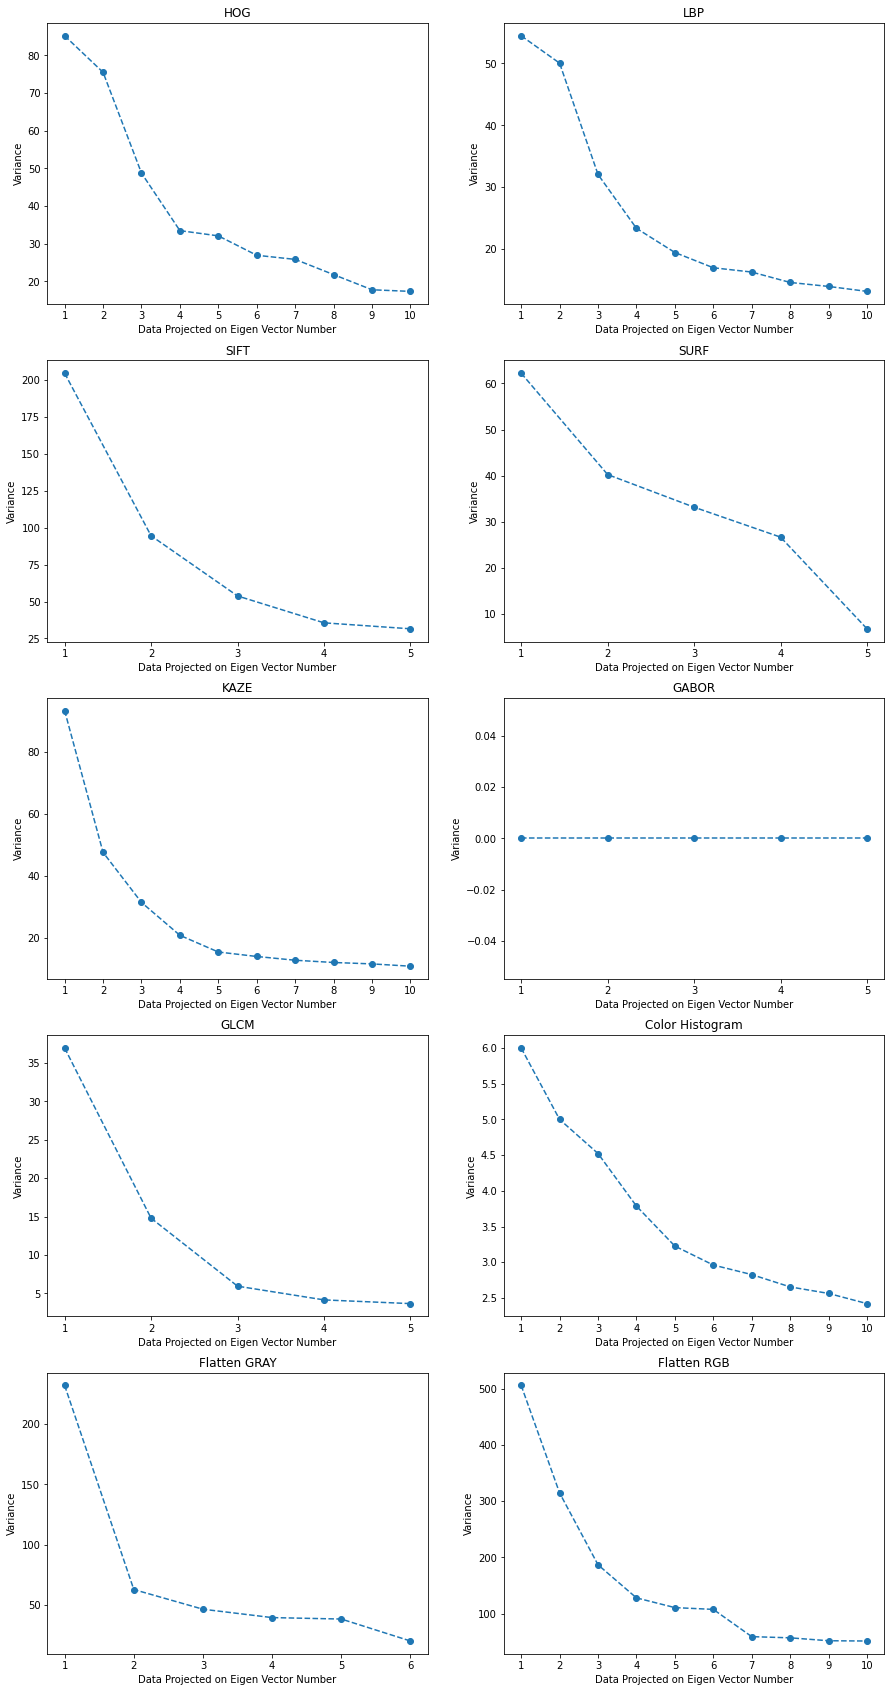

In [94]:
pca_projection(pca_array, ['HOG', 'LBP', 'SIFT', 'SURF', 'KAZE', 'GABOR', 'GLCM', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

### Reduce Features by LDA:

#### HOG Features:

In [177]:
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)

In [178]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [179]:
np.save('cache/lda_hog_train.npy', lda_hog_train)
np.save('cache/lda_hog_val.npy', lda_hog_val)

In [95]:
lda_hog_train = np.load('cache/lda_hog_train.npy')
lda_hog_val = np.load('cache/lda_hog_val.npy')

In [96]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

#### LBP Features:

In [182]:
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)

In [183]:
np.save('cache/lda_lbp_train.npy', lda_lbp_train)
np.save('cache/lda_lbp_val.npy', lda_lbp_val)

In [97]:
lda_lbp_train = np.load('cache/lda_lbp_train.npy')
lda_lbp_val = np.load('cache/lda_lbp_val.npy')

In [98]:
lda_lbp_train.shape, lda_lbp_val.shape

((17636, 1), (4410, 1))

#### SIFT:

In [186]:
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)

In [187]:
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)

In [99]:
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

In [100]:
lda_sift_train.shape, lda_sift_val.shape

((17636, 1), (4410, 1))

#### Color Histogram:

In [190]:
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)

In [191]:
np.save('cache/lda_hist_train.npy', lda_hist_train)
np.save('cache/lda_hist_val.npy', lda_hist_val)

In [101]:
lda_hist_train = np.load('cache/lda_hist_train.npy')
lda_hist_val = np.load('cache/lda_hist_val.npy')

In [102]:
lda_hist_train.shape, lda_hist_val.shape

((17636, 1), (4410, 1))

### Combine Features normal:

In [194]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train, surf_train, flat_rgb_train, lbp_train, kaze_train, sift_train, gabor_train, glcm_train], 
                  [hog_val, hist_val, surf_val, flat_rgb_val, lbp_val, kaze_val, sift_val, gabor_val, glcm_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [174]:
features_train.shape, features_val.shape

((17636, 10596), (4410, 10596))

### Combine Features PCA:

In [104]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train, pca_sift_train, pca_flat_rgb_train, pca_hist_train, pca_glcm_train], 
                  [pca_hog_val, pca_lbp_val, pca_sift_val, pca_flat_rgb_val, pca_hist_val, pca_glcm_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [105]:
features_train.shape, features_val.shape

((17636, 50), (4410, 50))

### Combine Features LDA:

In [106]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train, lda_sift_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val, lda_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [107]:
features_train_lda.shape, features_val_lda.shape

((17636, 4), (4410, 4))

### LDA on PCA

In [108]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

In [109]:
np.save('cache/lda_on_pca_train.npy', lda_on_pca_train)
np.save('cache/lda_on_pca_val.npy', lda_on_pca_val)

In [110]:
lda_on_pca_train = np.load('cache/lda_on_pca_train.npy')
lda_on_pca_val = np.load('cache/lda_on_pca_val.npy')

In [111]:
lda_on_pca_train.shape, lda_on_pca_val.shape

((17636, 1), (4410, 1))

### Combine Features:

In [112]:
features_t = pca_hist_train
features_v = pca_hist_val

In [113]:
features_t.shape, features_v.shape

((17636, 10), (4410, 10))

## Classification:

### PCA

In [207]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.8689342403628117
[[1872  340]
 [ 238 1960]]
Recall in 'RF' = 0.8462929475587704
Precision in 'RF' = 0.8872037914691943
F1 Score in 'RF' = 0.866265617769551


In [208]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [209]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.8773242630385487
[[1910  302]
 [ 239 1959]]
Recall in 'BAG' = 0.8634719710669078
Precision in 'BAG' = 0.8887854816193579
F1 Score in 'BAG' = 0.8759458839715663


In [210]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [211]:
model3 = train_model(features_train, train_y, model_name='ADA', validation=(features_val, val_y))

Validation Accuracy in 'ADA' = 0.8650793650793651
[[1861  351]
 [ 244 1954]]
Recall in 'ADA' = 0.8413200723327305
Precision in 'ADA' = 0.8840855106888361
F1 Score in 'ADA' = 0.8621728051887885


In [212]:
prob3 = model3.predict_proba(features_val)
prob30 = prob3[:,0].reshape(prob3.shape[0], 1)
prob31 = prob3[:,1].reshape(prob3.shape[0], 1)

In [213]:
model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6616780045351474
[[ 913 1299]
 [ 193 2005]]
Recall in 'NB' = 0.412748643761302
Precision in 'NB' = 0.825497287522604
F1 Score in 'NB' = 0.5503315250150693


In [214]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [215]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.861904761904762
[[1892  320]
 [ 289 1909]]
Recall in 'SVM' = 0.8553345388788427
Precision in 'SVM' = 0.8674919761577258
F1 Score in 'SVM' = 0.8613703619394492


In [216]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [217]:
model6 = train_model(np.array(features_train), train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.9129251700680272
[[1974  238]
 [ 146 2052]]
Recall in 'XGB' = 0.8924050632911392
Precision in 'XGB' = 0.9311320754716981
F1 Score in 'XGB' = 0.9113573407202217


In [218]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [219]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.780045351473923
[[1646  566]
 [ 404 1794]]
Recall in 'KNN' = 0.744122965641953
Precision in 'KNN' = 0.8029268292682927
F1 Score in 'KNN' = 0.7724073205068044


In [220]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

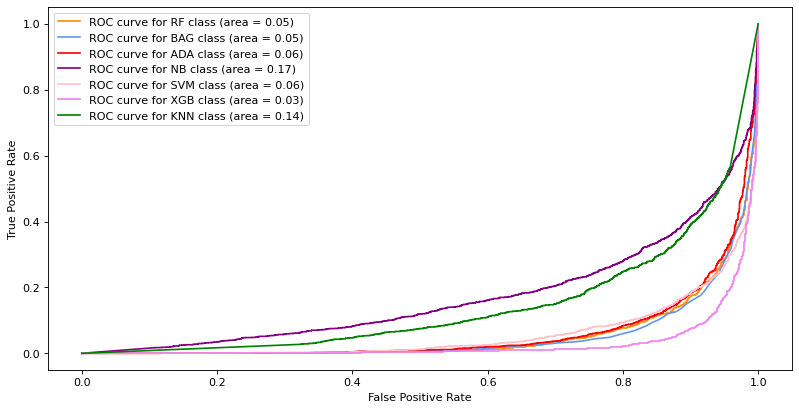

In [133]:
prob = np.concatenate((prob10, prob20, prob30, prob40, prob50, prob60, prob70), axis=1)
plot_combine_roc(val_y, prob)

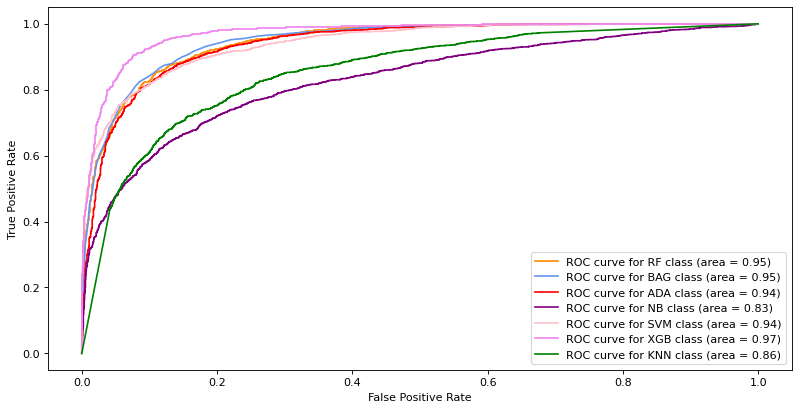

In [134]:
prob = np.concatenate((prob11, prob21, prob31, prob41, prob51, prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

### LDA

In [135]:
model8 = train_model(features_train_lda, train_y, model_name='RF', validation=(features_val_lda, val_y))

Validation Accuracy in 'RF' = 0.8428571428571429
[[1839  373]
 [ 320 1878]]
Recall in 'RF' = 0.831374321880651
Precision in 'RF' = 0.8517832329782307
F1 Score in 'RF' = 0.841455044612217


In [136]:
prob8 = model8.predict_proba(features_val_lda)
prob80 = prob8[:,0].reshape(prob8.shape[0], 1)
prob81 = prob8[:,1].reshape(prob8.shape[0], 1)

In [137]:
model9 = train_model(features_train_lda, train_y, model_name='BAG', validation=(features_val_lda, val_y))

Validation Accuracy in 'BAG' = 0.8405895691609977
[[1834  378]
 [ 325 1873]]
Recall in 'BAG' = 0.8291139240506329
Precision in 'BAG' = 0.8494673459935155
F1 Score in 'BAG' = 0.8391672386181652


In [138]:
prob9 = model9.predict_proba(features_val_lda)
prob90 = prob9[:,0].reshape(prob9.shape[0], 1)
prob91 = prob9[:,1].reshape(prob9.shape[0], 1)

In [139]:
model10 = train_model(features_train_lda, train_y, model_name='ADA', validation=(features_val_lda, val_y))

Validation Accuracy in 'ADA' = 0.8399092970521542
[[1811  401]
 [ 305 1893]]
Recall in 'ADA' = 0.8187160940325497
Precision in 'ADA' = 0.8558601134215501
F1 Score in 'ADA' = 0.8368761552680222


In [140]:
prob10 = model10.predict_proba(features_val_lda)
prob100 = prob10[:,0].reshape(prob10.shape[0], 1)
prob101 = prob10[:,1].reshape(prob10.shape[0], 1)

In [141]:
model11 = train_model(features_train_lda, train_y, model_name='NB', validation=(features_val_lda, val_y))

Validation Accuracy in 'NB' = 0.845578231292517
[[1843  369]
 [ 312 1886]]
Recall in 'NB' = 0.8331826401446655
Precision in 'NB' = 0.8552204176334107
F1 Score in 'NB' = 0.8440577055186628


In [142]:
prob11 = model11.predict_proba(features_val_lda)
prob110 = prob11[:,0].reshape(prob11.shape[0], 1)
prob111 = prob11[:,1].reshape(prob11.shape[0], 1)

In [143]:
model12 = train_model(features_train_lda, train_y, model_name='SVM', validation=(features_val_lda, val_y))

Validation Accuracy in 'SVM' = 0.8555555555555555
[[1890  322]
 [ 315 1883]]
Recall in 'SVM' = 0.8544303797468354
Precision in 'SVM' = 0.8571428571428571
F1 Score in 'SVM' = 0.8557844690966719


In [144]:
prob12 = model12.predict_proba(features_val_lda)
prob120 = prob12[:,0].reshape(prob12.shape[0], 1)
prob121 = prob12[:,1].reshape(prob12.shape[0], 1)

In [145]:
model13 = train_model(features_train_lda, train_y, model_name='XGB', validation=(features_val_lda, val_y))

Validation Accuracy in 'XGB' = 0.8360544217687075
[[1819  393]
 [ 330 1868]]
Recall in 'XGB' = 0.8223327305605787
Precision in 'XGB' = 0.8464402047463937
F1 Score in 'XGB' = 0.8342123366200412


In [146]:
prob13 = model13.predict_proba(features_val_lda)
prob130 = prob13[:,0].reshape(prob13.shape[0], 1)
prob131 = prob13[:,1].reshape(prob13.shape[0], 1)

In [147]:
model14 = train_model(features_train_lda, train_y, model_name='KNN', validation=(features_val_lda, val_y))

Validation Accuracy in 'KNN' = 0.8317460317460318
[[1827  385]
 [ 357 1841]]
Recall in 'KNN' = 0.8259493670886076
Precision in 'KNN' = 0.8365384615384616
F1 Score in 'KNN' = 0.8312101910828025


In [148]:
prob14 = model14.predict_proba(features_val_lda)
prob140 = prob14[:,0].reshape(prob14.shape[0], 1)
prob141 = prob14[:,1].reshape(prob14.shape[0], 1)

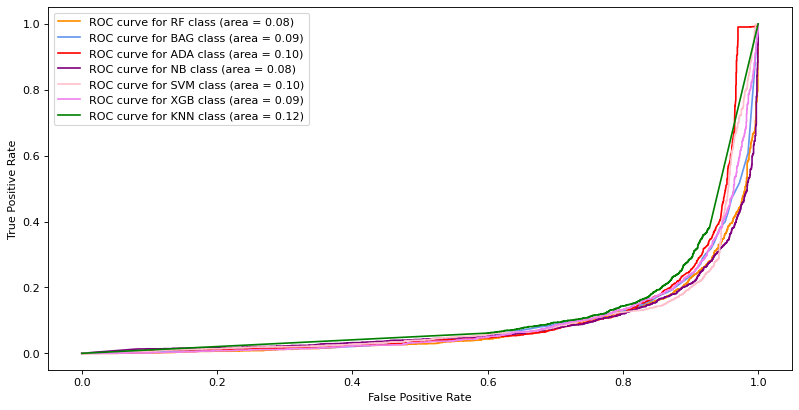

In [149]:
prob = np.concatenate((prob80, prob90, prob100, prob110, prob120, prob130, prob140), axis=1)
plot_combine_roc(val_y, prob)

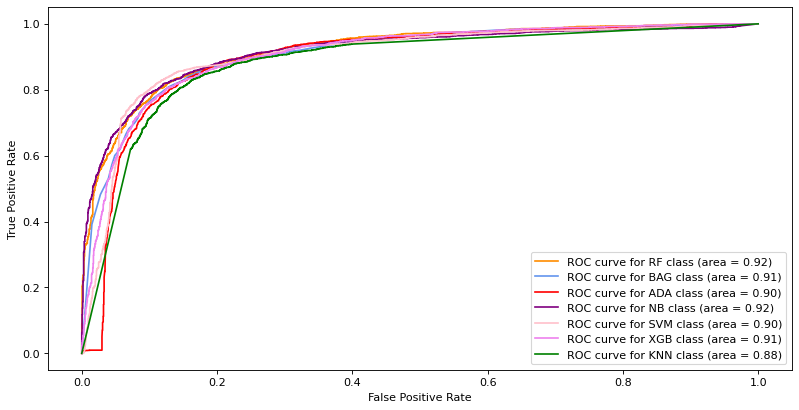

In [150]:
prob = np.concatenate((prob81, prob91, prob101, prob111, prob121, prob131, prob141), axis=1)
plot_combine_roc(val_y, prob)

### LDA on PCA

In [151]:
model15 = train_model(lda_on_pca_train, train_y, model_name='RF', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'RF' = 0.8333333333333334
[[1878  334]
 [ 401 1797]]
Recall in 'RF' = 0.849005424954792
Precision in 'RF' = 0.824045634050022
F1 Score in 'RF' = 0.8363393453573814


In [152]:
prob15 = model15.predict_proba(lda_on_pca_val)
prob150 = prob15[:,0].reshape(prob15.shape[0], 1)
prob151 = prob15[:,1].reshape(prob15.shape[0], 1)

In [153]:
model16 = train_model(lda_on_pca_train, train_y, model_name='BAG', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'BAG' = 0.7623582766439909
[[1660  552]
 [ 496 1702]]
Recall in 'BAG' = 0.7504520795660036
Precision in 'BAG' = 0.7699443413729128
F1 Score in 'BAG' = 0.76007326007326


In [154]:
prob16 = model16.predict_proba(lda_on_pca_val)
prob160 = prob16[:,0].reshape(prob16.shape[0], 1)
prob161 = prob16[:,1].reshape(prob16.shape[0], 1)

In [155]:
model17 = train_model(lda_on_pca_train, train_y, model_name='ADA', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'ADA' = 0.8333333333333334
[[1866  346]
 [ 389 1809]]
Recall in 'ADA' = 0.8435804701627486
Precision in 'ADA' = 0.8274944567627495
F1 Score in 'ADA' = 0.8354600402955004


In [156]:
prob17 = model17.predict_proba(lda_on_pca_val)
prob170 = prob17[:,0].reshape(prob17.shape[0], 1)
prob171 = prob17[:,1].reshape(prob17.shape[0], 1)

In [157]:
model18 = train_model(lda_on_pca_train, train_y, model_name='NB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'NB' = 0.8206349206349206
[[1694  518]
 [ 273 1925]]
Recall in 'NB' = 0.7658227848101266
Precision in 'NB' = 0.8612099644128114
F1 Score in 'NB' = 0.8107202680067002


In [158]:
prob18 = model18.predict_proba(lda_on_pca_val)
prob180 = prob18[:,0].reshape(prob18.shape[0], 1)
prob181 = prob18[:,1].reshape(prob18.shape[0], 1)

In [159]:
model19 = train_model(lda_on_pca_train, train_y, model_name='SVM', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'SVM' = 0.8319727891156462
[[1854  358]
 [ 383 1815]]
Recall in 'SVM' = 0.8381555153707052
Precision in 'SVM' = 0.8287885561019223
F1 Score in 'SVM' = 0.8334457181389077


In [160]:
prob19 = model19.predict_proba(lda_on_pca_val)
prob190 = prob19[:,0].reshape(prob19.shape[0], 1)
prob191 = prob19[:,1].reshape(prob19.shape[0], 1)

In [161]:
model20 = train_model(lda_on_pca_train, train_y, model_name='XGB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'XGB' = 0.8331065759637188
[[1870  342]
 [ 394 1804]]
Recall in 'XGB' = 0.8453887884267631
Precision in 'XGB' = 0.8259717314487632
F1 Score in 'XGB' = 0.8355674709562109


In [162]:
prob20 = model20.predict_proba(lda_on_pca_val)
prob200 = prob20[:,0].reshape(prob20.shape[0], 1)
prob201 = prob20[:,1].reshape(prob20.shape[0], 1)

In [163]:
model21 = train_model(lda_on_pca_train, train_y, model_name='KNN', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'KNN' = 0.7882086167800454
[[1727  485]
 [ 449 1749]]
Recall in 'KNN' = 0.780741410488246
Precision in 'KNN' = 0.7936580882352942
F1 Score in 'KNN' = 0.7871467639015498


In [164]:
prob21 = model21.predict_proba(lda_on_pca_val)
prob210 = prob21[:,0].reshape(prob21.shape[0], 1)
prob211 = prob21[:,1].reshape(prob21.shape[0], 1)

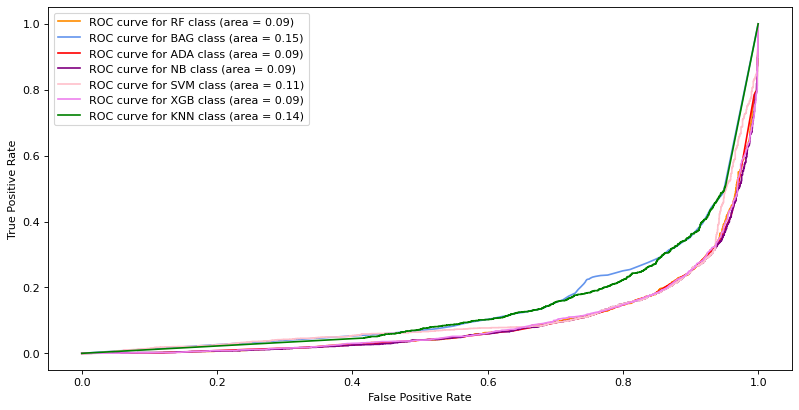

In [165]:
prob = np.concatenate((prob150, prob160, prob170, prob180, prob190, prob200, prob210), axis=1)
plot_combine_roc(val_y, prob)

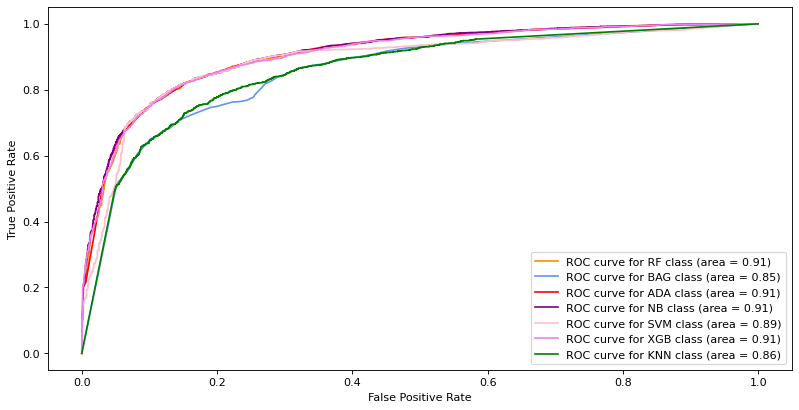

In [166]:
prob = np.concatenate((prob151, prob161, prob171, prob181, prob191, prob201, prob211), axis=1)
plot_combine_roc(val_y, prob)

## Testing

In [169]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
lbp_comp_train = combine_features([lbp_train, lbp_val], horizontal=False)
kaze_comp_train = combine_features([kaze_train, kaze_val], horizontal=False)
sift_comp_train = combine_features([sift_train, sift_val], horizontal=False)
surf_comp_train = combine_features([surf_train, surf_val], horizontal=False)
gabor_comp_train = combine_features([gabor_train, gabor_val], horizontal=False)
glcm_comp_train = combine_features([glcm_train, glcm_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [170]:
data_y = np.hstack([train_y, val_y])

In [171]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=30)
pca_lbp_comp_train = pca.fit_transform(lbp_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_kaze_comp_train = pca.fit_transform(kaze_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=15)
pca_sift_comp_train = pca.fit_transform(sift_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=5)
pca_surf_comp_train = pca.fit_transform(surf_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=5)
pca_gabor_comp_train = pca.fit_transform(gabor_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=5)
pca_glcm_comp_train = pca.fit_transform(glcm_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

/home/arijitiiest/Desktop/Workspace/Project/Malaria Detection/env/lib/python3.6/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [172]:
reduced_train_features=[pca_hog_comp_train,
                        pca_lbp_comp_train,
                        pca_kaze_comp_train,
                        pca_sift_comp_train,
                        pca_surf_comp_train,
                        pca_gabor_comp_train,
                        pca_glcm_comp_train,
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [173]:
hog_test = get_hog(test_x, name='hog_test', save=True)
lbp_test = get_lbp(test_x, name='lbp_test', save=True)
kaze_test = get_kaze(test_x, name='kaze_test', save=True)
sift_test = get_sift(test_x, name='sift_test', save=True)
surf_test = get_surf(test_x, name='surf_test', save=True)
gabor_test = get_gabor(test_x, name='gabor_test', save=True)
glcm_test = get_glcm(test_x, name='glcm_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/lbp_test.pkl
Feature saved with name cache/kaze_test.pkl
Feature saved with name cache/sift_test.pkl
Feature saved with name cache/surf_test.pkl
Feature saved with name cache/gabor_test.pkl
Feature saved with name cache/glcm_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [174]:
test_features= [hog_test,
                lbp_test,
                kaze_test,
                sift_test,
                surf_test,
                gabor_test,
                glcm_test,
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [175]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 6:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [176]:
features_comp_train.shape, features_test.shape

((22046, 135), (5512, 135))

In [177]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [178]:
y_hat = comp_model.predict(features_test)

In [179]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.8450653120464441
[[2306  417]
 [ 437 2352]]
0.8406853809697412 0.8468600807932427 0.8437614343212587


### CM

In [180]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)
y_hat3 = model3.predict(features_val)
y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

In [181]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)
cm3 = MetricTools.confusion_matrix(val_y, y_hat3, 2)
cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [182]:
print(cm1)
print(cm2)
print(cm3)
print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[1876.  336.]
 [ 248. 1950.]]
[[1902.  310.]
 [ 242. 1956.]]
[[1861.  351.]
 [ 244. 1954.]]
[[ 913. 1299.]
 [ 193. 2005.]]
[[1892.  320.]
 [ 289. 1909.]]
[[1974.  238.]
 [ 146. 2052.]]
[[1646.  566.]
 [ 404. 1794.]]


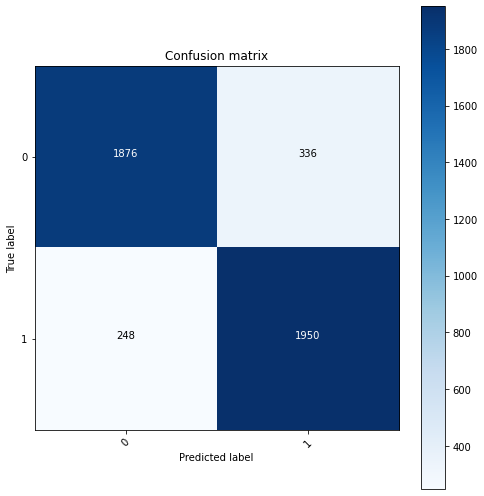

In [199]:
PlotTools.confusion_matrix(cm1, list(range(2)))

### Model Stacking:

In [200]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train, pca_lbp_train], 
                  [pca_hist_val, pca_hog_val, pca_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((17636, 30), (4410, 30))

In [201]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.8990929705215419
[[1958  254]
 [ 191 2007]]
Recall in 'XGB' = 0.8851717902350814
Precision in 'XGB' = 0.9111214518380643
F1 Score in 'XGB' = 0.8979591836734695


In [202]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((17636, 26), (4410, 26))

In [203]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.8893424036281179
[[1894  318]
 [ 170 2028]]
Recall in 'XGB' = 0.85623869801085
Precision in 'XGB' = 0.9176356589147286
F1 Score in 'XGB' = 0.8858746492048644


In [204]:
features_train3 = None
features_val3 = None
evs = []
for ft, fv in zip([pca_kaze_train, pca_sift_train, pca_surf_train], 
                  [pca_kaze_val, pca_sift_val, pca_surf_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train3 is None:
        features_train3 = ft
        features_val3 = fv
    else:
        features_train3 = combine_features([features_train3, ft])
        features_val3 = combine_features([features_val3, fv])
features_train3.shape, features_val3.shape

((17636, 20), (4410, 20))

In [205]:
model3 = train_model(features_train3, train_y, model_name='XGB', validation=(features_val3, val_y))
prob3 = model3.predict_proba(features_val3)

Validation Accuracy in 'XGB' = 0.754421768707483
[[1508  704]
 [ 379 1819]]
Recall in 'XGB' = 0.6817359855334539
Precision in 'XGB' = 0.7991520932697403
F1 Score in 'XGB' = 0.7357892168821665


In [221]:
prob1 = model1.predict_proba(features_val)
prob2 = model2.predict_proba(features_val)
prob3 = model3.predict_proba(features_val)
prob4 = model4.predict_proba(features_val)
#prob5 = model5.score(features_val, )
prob6 = model6.predict_proba(features_val)

In [238]:
prob = (prob1 + prob2 + prob3 + prob4 + prob6) / 5
y_hat = np.argmax(prob, axis=1)

In [239]:
metrics.accuracy_score(val_y, y_hat)

0.8843537414965986

In [240]:
# y_hat = model.predict(features_val)

In [241]:
cm = MetricTools.confusion_matrix(val_y, y_hat, 2)

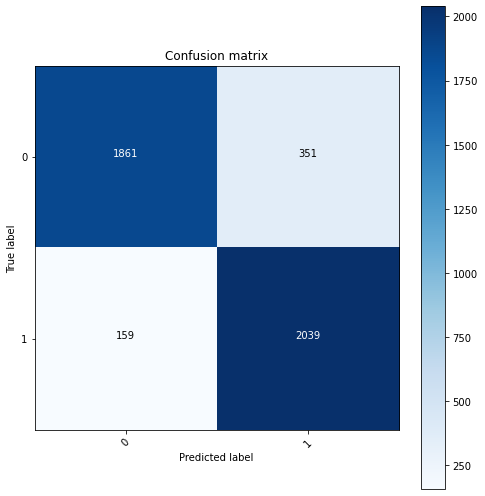

In [242]:
PlotTools.confusion_matrix(cm, list(range(2)))

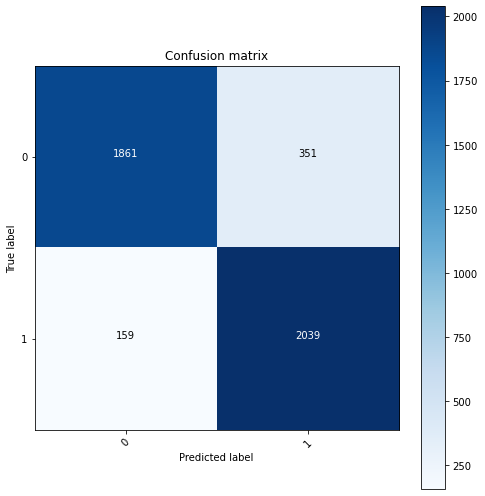

In [243]:
PlotTools.confusion_matrix(cm, list(range(2)))